<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Demonstration-Dimensionless-Learning-for-Keyhole-Dynamics" data-toc-modified-id="Demonstration-Dimensionless-Learning-for-Keyhole-Dynamics-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Demonstration Dimensionless Learning for Keyhole Dynamics</a></span></li><li><span><a href="#Import-libraries" data-toc-modified-id="Import-libraries-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import libraries</a></span></li><li><span><a href="#Parametric-space-analysis" data-toc-modified-id="Parametric-space-analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Parametric space analysis</a></span><ul class="toc-item"><li><span><a href="#Load-dataset" data-toc-modified-id="Load-dataset-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Load dataset</a></span></li><li><span><a href="#Calculate-dimension-matrix" data-toc-modified-id="Calculate-dimension-matrix-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Calculate dimension matrix</a></span></li><li><span><a href="#Calculate-basis-vectors" data-toc-modified-id="Calculate-basis-vectors-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Calculate basis vectors</a></span></li></ul></li><li><span><a href="#Helper-functions" data-toc-modified-id="Helper-functions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Helper functions</a></span></li><li><span><a href="#Best-representation-learning-discovery" data-toc-modified-id="Best-representation-learning-discovery-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Best representation learning discovery</a></span></li><li><span><a href="#Reference" data-toc-modified-id="Reference-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

# Demonstration Dimensionless Learning for Keyhole Dynamics 

- **Authors**: Xiaoyu Xie, Zhengtao Gan
- **Contact**: xiaoyuxie2020@u.northwestern.edu
- **Date**: Oct. 2021

# Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import matrix_rank
from numpy.linalg import inv
import pandas as pd
import pysindy as ps
import random
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.optimize import minimize

# Parametric space analysis

Paraemter list:

$f(\eta P,V_s,r_0, C_p, \alpha, \rho, T_l-T_0)=e$

## Load dataset

In [2]:
data = np.loadtxt(
    open("../dataset/keyhole_data.csv","rb"),
    delimiter=',',
    skiprows=1,
    usecols = (2,3,5,7,8,9,12,14)
)
X = data[:,0:7]
Y = data[:,7]

## Calculate dimension matrix

Dimension matrix (input):

\begin{equation}  
D_{in}=
\left[                
  \begin{array}{ccc}  
    2 & 1 & 1 & 2 &2&-3&0\\  
    -3 & -1 & 0 & -2 &-1&0&0\\  
    1& 0 & 0 & 0 &0&1&0\\
    0& 0 & 0 & -1 &0&0&1\\
  \end{array}
\right]              
\end{equation}

Dimension matrix (output):

\begin{equation}
D_{out}=
\left[                
  \begin{array}{ccc}  
    1 \\  
    0 \\  
    0 \\
    0 \\
  \end{array}
\right]              
\end{equation}

In [3]:
D_in = np.mat('2,1,1,2,2,-3,0; -3,-1,0,-2,-1,0,0; 1,0,0,0,0,1,0;0,0,0,-1,0,0,1')
D_out = np.mat('1;0;0;0')
D_in_rank = matrix_rank(D_in)
print(D_in_rank)

4


## Calculate basis vectors

Calculate three basis vectors for equation:
$
D_{in}x=0
$


In [4]:
Din1 = D_in[:, 0:4]
Din2 = D_in[:, 4:8]

x2 = np.mat('-1; 0; 0')
x1 = -inv(Din1) * Din2 * x2
basis1_in = np.vstack((x1, x2))
print(f'basis1_in: \n{basis1_in}')

x2 = np.mat('0;-1;0')
x1 = -inv(Din1) * Din2 * x2
basis2_in = np.vstack((x1, x2))
print(f'basis2_in: \n{basis2_in}')

x2 = np.mat('0; 0; -1')
x1 = -inv(Din1) * Din2 * x2
basis3_in = np.vstack((x1, x2))
print(f'basis3_in: \n{basis3_in}')

basis1_in: 
[[ 0.]
 [ 1.]
 [ 1.]
 [ 0.]
 [-1.]
 [ 0.]
 [ 0.]]
basis2_in: 
[[ 1.]
 [-3.]
 [-2.]
 [ 0.]
 [ 0.]
 [-1.]
 [ 0.]]
basis3_in: 
[[ 0.00000000e+00]
 [ 2.00000000e+00]
 [-3.70074342e-17]
 [-1.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [-1.00000000e+00]]


# Helper functions

In [5]:
def calc_pi(a):
    '''
    Calculate pi
    Note that the best coef for keyhole is [0.5, 1, 1]
    '''
    coef_pi = 0.5 * basis1_in + a[0] * basis2_in + a[1] * basis3_in
    pi_mat = np.exp(np.log(X).dot(coef_pi))
    pi = np.squeeze(np.asarray(pi_mat))
    return pi

def calc_y(a, w):
    '''
    Calculate the prediction y using a polynomial function
    '''
    pi = calc_pi(a)
    y = w[0] + w[1] * pi + w[2] * pi**2 + w[3] * pi**3 + w[4] * pi**4 + w[5] * pi**5
    return y

def objective(a, w):
    '''
    Calculate objective(loss)
    '''
    return np.square(pi2 - calc_y(a, w)).mean()

def ploter(pi1, pi2, iteration):
    fig = plt.figure()
    plt.scatter(pi1, pi2)
    plt.xlabel('pi1', fontsize=16)
    plt.ylabel('pi2', fontsize=16)
    plt.title(f'iteration: {iteration}', fontsize=24)
    plt.show()

# Best representation learning discovery

Initial a=[0.47592925 1.08845845]
Iteration: 0, coef: [0.47655419 1.08822938], Objective: 6.775658045770944


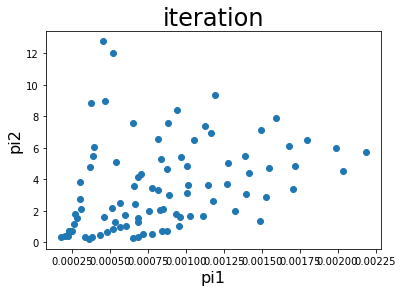

Iteration: 1000, coef: [0.83230304 0.91861095], Objective: 0.3475122152888207


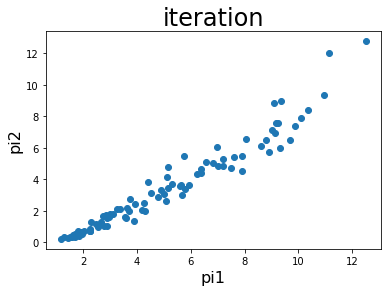

Iteration: 2000, coef: [0.8815391  0.88536812], Objective: 0.10914143504481646


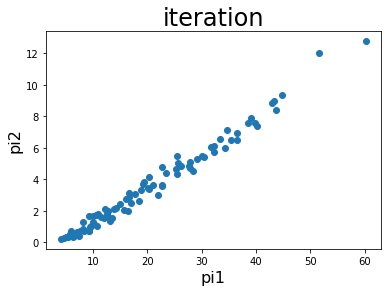

In [6]:
random.seed(3)

niter = 3000
ninital = 1

a = np.zeros(2)
w = np.zeros(6)

global pi2
pi2 = Y / X[:,2]

feature_library = ps.PolynomialLibrary(degree=5)
optimizer =LinearRegression(fit_intercept=False)

for j in range(ninital):
    a[0] = 2 * random.random()
    a[1] = 2 * random.random()
    print(f'Initial a={a}') 
    
    info = {}
    info['initial'] = a
    a_history = np.zeros((niter, 2))
    
    model = ps.SINDy(feature_library=feature_library, optimizer=optimizer)

    for i in range(niter):
        # update coefficient w for polynomials
        pi1 = calc_pi(a)
        
        model.fit(pi1, x_dot=pi2);
        coeffi = model.coefficients()
        w = coeffi[0]
        y_recover = calc_y(a, w)       
        r2 = r2_score(y_recover, pi2)

        # update coefficient a for pi
        solution = minimize(objective, a, method='BFGS', tol=1e-3, args=w, options={'maxiter':1})
        a = solution.x
        y_recover = calc_y(a,w)
        r2 = r2_score(y_recover, pi2) 

        a_history[i,:] = a
        if i % 1000 == 0:
            # Note that the best coef in keyhole case is [0.5, 1, 1]
            # here we only optimize the last two coefficients
            print(f'Iteration: {i}, coef: {a}, Objective: {objective(a,w)}')
            ploter(pi1, pi2, i)

# Reference

- [1] Saha, S., **Gan, Z.**, Cheng, L., Gao, J., Kafka, O. L., **Xie, X.**, Li, H., Tajdari, M., Kim, H. A., & Liu, W. K. (2021). Hierarchical Deep Learning Neural Network (HiDeNN): An artificial intelligence (AI) framework for computational science and engineering. Computer Methods in Applied Mechanics and Engineering, 373, 113452. https://doi.org/10.1016/j.cma.2020.113452
- [2] **Xie, X.**, Liu, W. K., **Gan, Z.** (2021). Data-driven discovery of dimensionless numbers and scaling laws from experimental measurements (In preparation)